In [19]:
import numpy as np
import csv
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import dok_matrix
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
train_file = 'train.csv'
test_file  = 'test.csv'
soln_file  = 'user_median.csv'
V = []
# Load the training data.
train_data_user = {}
train_data_art = {}
with open(train_file, 'r') as train_fh:
    train_csv = csv.reader(train_fh, delimiter=',', quotechar='"')
    next(train_csv, None)
    for row in train_csv:
        V.append(int(row[2]))

In [39]:
V = np.array(V)
float(len(V[V<1000]))/len(V)

0.9602455374549558

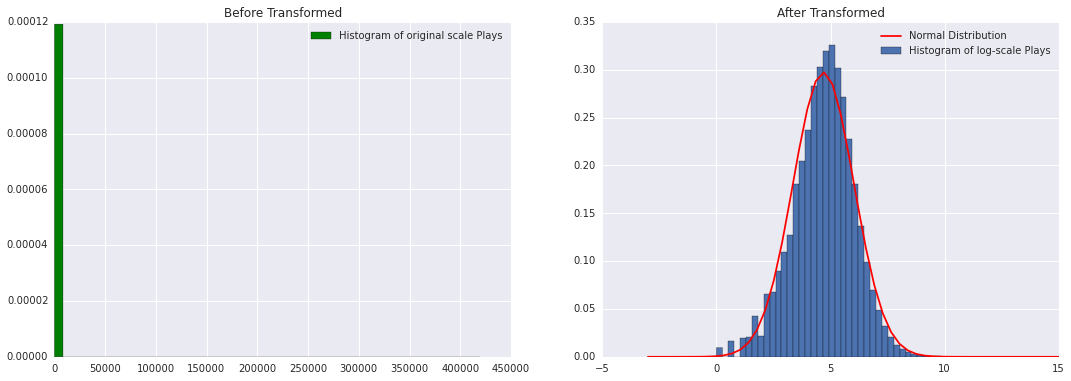

In [34]:
#x = np.linspace(-1, 50000)
#y = scipy.stats.norm.pdf(x, loc=np.mean(V), scale = np.std(V))
plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
plt.hist(V, bins=50, normed=True, label='Histogram of original scale Plays', color='g')
#plt.plot(x, y, label='Normal Distribution', color='r')
plt.title('Before Transformed')
plt.legend()

plt.subplot(1,2,2)
x = np.linspace(-3, 15)
y = scipy.stats.norm.pdf(x, loc=np.mean(np.log(V)), scale = np.std(np.log(V)))

plt.hist(np.log(V), bins=50, normed=True, label='Histogram of log-scale Plays')
plt.plot(x, y, label='Normal Distribution', color='r')
plt.title('After Transformed')
plt.legend()


plt.show()

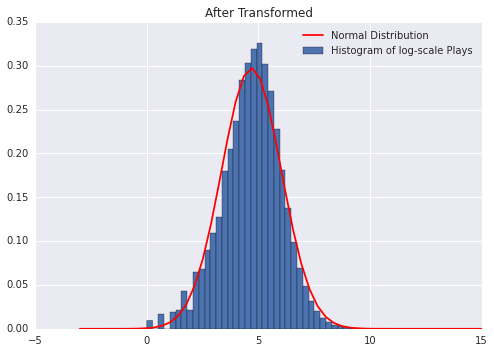

In [23]:
x = np.linspace(-3, 15)
y = scipy.stats.norm.pdf(x, loc=np.mean(np.log(V)), scale = np.std(np.log(V)))

plt.hist(np.log(V), bins=50, normed=True, label='Histogram of log-scale Plays')
plt.plot(x, y, label='Normal Distribution', color='r')
plt.title('After Transformed')
plt.legend()
plt.show()

In [12]:
import scipy.stats


In [14]:
?scipy.stats.norm.pdf()

In [11]:
train_file = 'train.csv'
test_file  = 'test.csv'
soln_file  = 'user_median.csv'

# Load the training data.
train_data_user = {}
train_data_art = {}
with open(train_file, 'r') as train_fh:
    train_csv = csv.reader(train_fh, delimiter=',', quotechar='"')
    next(train_csv, None)
    for row in train_csv:
        user   = row[0]
        artist = row[1]
        plays  = row[2]
    
        if not train_data_user.has_key(user):
            train_data_user[user] = {}
        if not train_data_art.has_key(artist):
            train_data_art[artist] = {}
        
        train_data_user[user][artist] = int(plays)
        train_data_art[artist][user] = int(plays)

In [12]:
users = train_data_user.keys()
artists = train_data_art.keys()

In [62]:
users_to_idx = {}
artists_to_idx = {}
for idx, user in enumerate(users):
    users_to_idx[user] = idx
    
for idx, artist in enumerate(artists):
    artists_to_idx[artist] = idx

In [95]:
len(artists), len(users)

(2000, 233286)

In [18]:
common_users = {}
common_artists = {}
for artist in train_data_user[users[0]].keys():
    common_artists[artist] = 0
    
for user in train_data_art[artists[0]].keys():
    common_users[user] = 0

In [23]:
for user in users:
    for artist in train_data_user[user].keys():
        if not common_artists.has_key(artist):
            continue
        else:
            common_artists[artist] += 1

In [26]:
for artist in artists:
    for user in train_data_art[artist].keys():
        if not common_users.has_key(user):
            continue
        else:
            common_users[user] += 1

In [20]:
len(common_artists), len(common_users)

(20, 847)

In [112]:
def matrix_factorization(R, P, Q, K, steps=10000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in xrange(steps):
        if not step%10: 
            print step,
            
        for i in xrange(R.shape[0]):
            for j in xrange(R.shape[1]):
                if R[i,j] > 0:
                    eij = R[i,j] - np.dot(P[i,:],Q[:,j])

                    for k in xrange(K):
                        P[i,:] + =  alpha * (2 * eij * Q[:,j] - beta * P[i,:])
                        Q[:,j] + =  alpha * (2 * eij * P[i,:] - beta * Q[:,j])
        eR = np.dot(P,Q)
        e = 0
        for i in xrange(R.shape[0]):
            for j in xrange(R.shape[1]):
                if R[i,j] > 0:
                    e = e + pow(R[i,j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in xrange(K):
                        e += (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        if not step%10: 
            print e
        
        
        if step>1 and abs(e-e_old) < 0.001:
            break
        e_old = e
    return P, Q.T

In [163]:
def matrix_factorization(P, Q, K, steps=20, alpha=0.00002, beta=0.001):
    Q = Q.T
    for step in xrange(steps):
        if not step%10: 
            print step,
            
        for i in xrange(len(users)):
            
            user = users[i]
            for artist, play in train_data_user[user].iteritems():
                j = artists_to_idx[artist]
                
                eij = play - np.dot(P[i,:],Q[:,j])

                for k in xrange(K):
                    P[i,:] +=  alpha * (2 * eij * Q[:,j] - beta * P[i,:])
                    Q[:,j] +=  alpha * (2 * eij * P[i,:] - beta * Q[:,j])

            if not i%100000: 
                print i,
                print P[i][0], Q[0][j], eij,';'
            
            
        #eR = np.dot(P,Q)
        e = 0
        for i in xrange(len(users)):
            user = users[i]
            for artist, play in train_data_user[user].iteritems():
                j = artists_to_idx[artist]
                
                e += pow(play - np.dot(P[i,:],Q[:,j]), 2)
                e += (beta/2) * np.sum(P[i,:]**2) + np.sum(Q[:,j]**2)
        if not step%10: 
            print e
        
        if step>1 and abs(e-e_old) < 0.001:
            break
        e_old = e
    return P, Q.T

In [172]:
P.shape, Q.shape

((233286L, 2L), (2000L, 2L))

In [271]:
np.max(P)

435.47251190580869

In [245]:
N = len(users)
M = len(artists)
K = 2

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

In [284]:
alpha = 0.000002
beta = 0.00002
start = time.time()
for i in xrange(len(users)):

    user = users[i]
    
    for artist, play in train_data_user[user].iteritems():
        
        j = artists_to_idx[artist]

        eij = play - np.dot(P[i],Q[j])
        if np.isnan(eij):
            print i, j
            break

        P[i] +=  alpha * (eij * Q[j] - beta * P[i])
        Q[j] +=  alpha * (eij * P[i] - beta * Q[j])

    if not i%10000:
        print i, eij
print "Time Elapsed:", time.time()-start

0 180.29499859
10000 880.643897239
20000 448.065776966
30000 135.421780156
40000 142.291808008
50000 309.688282274
60000 140.911484551
70000 -15.9245315873
80000 -1.91956809867
90000 10.5927441498
100000 470.780093731
110000 11.6148828502
120000 46.5181556003
130000 -5.68426131012
140000 -6.9066560219
150000 56.8616253224
160000 34.6277657162
170000 59.164305216
180000 25.5270406091
190000 -5.14479197362
200000 184.642215868
210000 82.7504766252
220000 79.0435295431
230000 -16.794019947
Time Elapsed: 117.866999865


In [285]:
e = 0
start = time.time()
for i in xrange(len(users)):
    user = users[i]
    for artist, play in train_data_user[user].iteritems():
        j = artists_to_idx[artist]

        e += (play - np.dot(P[i],Q[j]))**2
        e += (beta/2.) * np.sum(P[i]**2) + np.sum(Q[j]**2)
    if not i%10000:
        print i
print e
print "Time Elapsed:", time.time()-start

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
1.52025637974e+12
Time Elapsed: 112.230000019


In [280]:
start = time.time()
I = []
J = []
V = []
for i in xrange(len(users)):
    user = users[i]
    for artist, play in train_data_user[user].iteritems():
        j = artists_to_idx[artist]
        I.append(i)
        J.append(j)
        V.append(play)
    if not i%10000: print i
print "Time Elapsed:", time.time()-start

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
Time Elapsed: 9.52399992943


In [386]:
N = len(users)
M = len(artists)
K = 20

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

In [327]:
alpha = 0.000002
beta1 = 0.0002
beta2 = 0.002

In [354]:
e/len(I)

329367.81510947156

In [381]:
choose = np.random.choice(range(len(I)), size=10000, replace=False)

In [380]:
choose1 = choose.copy()

In [ ]:
choose1 = np.random.choice(range(len(I)), size=10000, replace=False)

In [390]:
start = time.time()
steps=100
for step in xrange(steps):
    choose = np.random.choice(range(len(I)), size=1000000, replace=False)
    for idx in choose:
    #for idx in xrange(len(I)):
        i = I[idx]
        j = J[idx]
        play = V[idx]
        eij = play - np.dot(P[i],Q[j])

        if np.isnan(eij):
            print i, j
            break

        P[i] +=  alpha * (eij * Q[j] - beta1 * P[i])
        Q[j] +=  alpha * (eij * P[i] - beta2 * Q[j])
    
    e = np.sum((V[choose] - np.sum(P[I[choose]]*Q[J[choose]], axis=1))**2)
    e += beta1*np.sum(P[I[choose]]**2) + beta2*np.sum(Q[J[choose]]**2)
    #e = np.sum((V - np.sum(P[I]*Q[J], axis=1))**2)
    #e += beta1*np.sum(P[I]**2) + beta2*np.sum(Q[J]**2)
    #if not step%50: 
    print step, e/len(choose)
    
    if step>1 and abs(e-e_old) < 0.001:
        break
    e_old = e

print "Time Elapsed:", time.time()-start

0 508036.115008
1 534900.702212
2 452252.640307
3 404279.232105
4 463772.753386
5 488521.384662
6 627854.228898
7 429377.258869
8 492841.821003
9 478159.331116
10 485701.308808
11 416445.172756
12 349016.356151
13 461039.086377
14 468695.798489
15 433095.81956
16 449462.199423
17 437897.370508
18 352388.342527
19 399065.278025
20 419195.693359
21 356177.566947
22 316487.721165
23 357506.545809
24 359360.070835
25 353285.459238
26 293666.862126
27 319627.151527
28 294658.004167
29 306681.439754
30 308997.9402
31 316111.249634
32 327830.182016
33 307572.826636
34 380714.511546
35 329269.810483
36 313323.990642
37 322058.648024
38 298622.686759
39 292014.632271
40 305790.787871
41 278983.031699
42 312405.868514
43 265562.995091
44 296198.890785
45 281833.175395
46 291119.566425
47 279086.615678
48 296832.219376
49 258504.557816
50 254420.997453
51 268137.379667
52 279355.678215
53 254207.276603
54 257191.929898
55 249645.820256
56 239525.770636
57 272888.069481
58 255285.900225
59 254350.

In [388]:
start = time.time()
e = np.sum((V[choose] - np.sum(P[I[choose]]*Q[J[choose]], axis=1))**2)
e += beta1*np.sum(P[I[choose]]**2) + beta2*np.sum(Q[J[choose]]**2)
print e/len(choose)
print "Time Elapsed:", time.time()-start

470853.666211
Time Elapsed: 1.97699999809


In [ ]:
start = time.time()
e = np.sum((V - np.sum(P[I]*Q[J], axis=1))**2)
e += beta1*np.sum(P[I]**2) + beta2*np.sum(Q[J]**2)
print e/len(I)
print "Time Elapsed:", time.time()-start

In [ ]:
347792

In [359]:
I = np.array(I)
J = np.array(J)
V = np.array(V)

In [348]:
print e, e_old

1.36845871569e+12 1.36845871569e+12


In [336]:
print e

2.40127606337e+12


In [393]:
P_tmp = pickle.load(open('P.p', 'r'))

In [394]:
import cPickle as pickle
pickle.dump(P, open('P.p', 'wb'))
pickle.dump(Q, open('Q.p', 'wb'))

In [395]:
pickle.dump(I, open('I.p', 'wb'))
pickle.dump(J, open('J.p', 'wb'))
pickle.dump(V, open('V.p', 'wb'))

In [ ]:
for i in xrange(len(users)):
    user = users[i]
    for artist, play in train_data_user[user].iteritems():
        j = artists_to_idx[artist]

In [166]:
start = time.time()
nP, nQ = matrix_factorization(P, Q, K)
nR = np.dot(nP, nQ.T)
print "Time Elapsed:", time.time()-start

0 0 0.712005673924 0.679239394448 239.268626932 ;
100000 nan nan nan ;
200000 nan nan nan ;


D:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: RuntimeWarning: overflow encountered in multiply
D:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: RuntimeWarning: invalid value encountered in subtract
D:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: RuntimeWarning: invalid value encountered in add
D:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: RuntimeWarning: overflow encountered in multiply


KeyboardInterrupt: 

In [173]:
i=1
user = users[i]
for artist, play in train_data_user[user].iteritems():
    j = artists_to_idx[artist]

    eij = play - np.dot(P[i,:],Q[j,:])
    print eij

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [170]:
Q[:,j]

IndexError: index 1109 is out of bounds for axis 1 with size 2

In [102]:
R = dok_matrix((len(users), len(artists)))
NotIncluded = dok_matrix((len(users), len(artists)))

In [ ]:
start = time.time()
for user in users:
    row = users_to_idx[user]
    for artist in train_data_user[user]:
        col = artists_to_idx[artist]
        tmp = np.random.uniform()
        if tmp<0.7:
            R[row,col] = train_data_user[user][artist]
        else:
            NotIncluded[row,col] = 1.
print "Time Elapsed:", time.time()-start

In [ ]:
import cPickle as pickle
pickle.dump(R, open('R.p', 'w'))
pickle.dump(NotIncluded, open('NotIncluded.p', 'w'))

In [94]:
I = np.array([0,3,1])
J = np.array([0,3,1])
V = np.array([4,5,7])
A = dok_matrix((V,(I,J)),shape=(4,4))

TypeError: expected rank <=2 dense array or matrix

In [131]:
P.shape

(233286L, 2L)

In [52]:
print nP
print nQ
print nR
print R

[[ 0.88212832  2.11979336]
 [ 0.70574379  1.61165683]
 [ 1.88371299 -0.31348649]
 [ 1.5253262  -0.18851496]
 [ 1.75664111  1.1940065 ]]
[[ 0.89216717  2.05033978]
 [ 0.52956859  0.80629099]
 [ 1.78560319  1.43442218]
 [ 2.56212101 -0.52475398]]
[[ 5.13330258  2.17631774  4.61580977  1.14774949]
 [ 3.93408554  1.67320412  3.57197468  0.96247766]
 [ 1.03783307  0.7447939   2.91389195  4.99080391]
 [ 0.97432624  0.65576693  2.45321729  4.00699429]
 [ 4.01533655  1.89297864  4.84937339  3.87416742]]
[[5 3 0 1]
 [4 0 0 1]
 [1 1 0 5]
 [1 0 0 4]
 [0 1 5 4]]
